In [1]:
import osmnx as ox
import networkx as nx
from network_resilience import *

# Extraindo o Grafo

O grafo extraído será referente ao centro da cidade de São Carlos, um quadrado de 2km de lado.
Isso será feito com a biblioteca osmnx

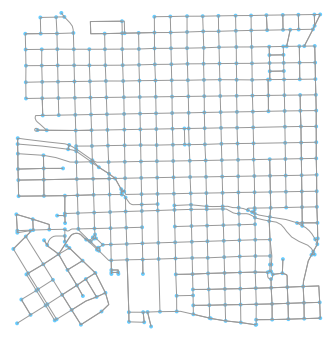

(<Figure size 456.079x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12295c28978>)

In [2]:
G = ox.graph_from_address('São Carlos, SP, Brasil', distance=1000, network_type='drive')
ox.plot_graph(G)

# Calculando a centralidade de intermediação e a adicionando ao grafo

In [3]:
G = nx.DiGraph(G)
bet = nx.edge_betweenness_centrality(G)
nx.set_edge_attributes(G, bet, 'betweenness')

In [4]:
e0, p0 = get_efficiency_and_connectivity(G, weight='length')
#p0 = p0 são os caminhos válidos originalmente, e0 = eficiência originalmente

# Degradando o grafo: vamos remover 10% das arestas com maior centralidade de intermediação
G_new = remove_edges_by_attr(G, attr='betweenness', remove_proportion=.10, ascending=False)

# Para o novo grafo, vamos calcular a conectividade e a eficiência (p1 e e1) 
e1, p1 = get_efficiency_and_connectivity(G_new, weight='length')

In [5]:
# calcula o decrescimo relativo em continuidade e eficiência 
conn = get_overall_connectivity(p1,p0)
eff = get_overall_efficiency(e1,e0)
print(f'Connectivity:\t{conn:.03f}\nEfficiency:\t{eff:.03f}')

Connectivity:	0.771
Efficiency:	0.700


In [6]:
#Continuidade e eficiência antes da degradação
e0, p0 = get_efficiency_and_connectivity(G, weight='length')
efficiencies={}
connectivity={}

#No loop, são removidas as arestas de 1% em 1%, até que todas sejam removidas, 
#e os parâmetros de continuidade e eficiência são calculados a cada passo.
for proportion in [r/100 for r in range(101)]:
    print(f'{int(proportion*100)}%', end='\r')
    G_new = remove_edges_by_attr(G, 'betweenness', proportion, ascending=False)
    e1, p1 = get_efficiency_and_connectivity(G_new, weight='length')
    efficiencies[proportion]=get_overall_efficiency(e1,e0)
    connectivity[proportion]=get_overall_connectivity(p1,p0)

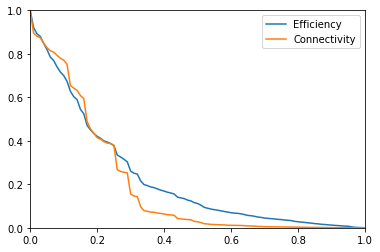

In [7]:
import matplotlib.pyplot as plt

#Plotando os resultados
plt.plot(list(efficiencies.keys()), list(efficiencies.values()), label='Efficiency')
plt.plot(list(connectivity.keys()), list(connectivity.values()), label='Connectivity')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

In [8]:
#Para calcular os índices, calcula-se a área sob a curva
import numpy as np

yc = list(connectivity.values())
ye = list(efficiencies.values())

#Choques brandos:
Cc1 = yc[1]
Ce1 = ye[1]

#Choques moderados:
Cc5 = yc[5]
Ce5 = ye[5]

#soma das áreas dos trapézios formados pelas curvas
Ic = np.trapz(yc, dx=.01)
Ie = np.trapz(ye, dx=.01)

print(f'Ic:     {Ic:.03f}\t\tIe:     {Ie:.03f}')
print(f'Cc(1%): {Cc1:.03f}\t\tCe(1%): {Ce1:.03f}')
print(f'Cc(5%): {Cc5:.03f}\t\tCe(5%): {Ce5:.03f}')

Ic:     0.192		Ie:     0.228
Cc(1%): 0.896		Ce(1%): 0.921
Cc(5%): 0.829		Ce(5%): 0.820
